In [4]:
import h5py
import numpy as np
import pandas as pd 

import fastdtw
import scipy.spatial.distance as sd

from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams["figure.figsize"] = [16,9]
sns.set_style('whitegrid')

GRID_SIZE = 0.06
LOWER_LAMBDA = 6472.5
UPPER_LAMBDA = 6740
PLOT_MASK = range(1475,1550)

In [2]:
hf_spec = h5py.File("/home/praveen/Documents/Research Data/resampled_emission_spectra.h5", "r")
hf_grid = h5py.File("/home/praveen/Documents/Research Data/wl_grid.h5", "r")

wl_grid = np.array(hf_grid["wl_grid"])
df = pd.DataFrame(hf_spec["spectra"])

In [3]:
hf_spec.close()
hf_grid.close()

In [6]:
df_masked = df.loc[:,PLOT_MASK]
df_masked_np = df_masked.to_numpy()

In [7]:
def my_fastdtw(spec1, spec2):
    return fastdtw.fastdtw(spec1, spec2)[0]

distance_matrix = sd.pdist(df_masked_np, my_fastdtw)

In [8]:
distance_matrix_square_form = sd.squareform(distance_matrix)

In [9]:
agglom = AgglomerativeClustering(n_clusters = 10, linkage = 'complete')
agglom.fit(distance_matrix_square_form)
agglom.labels_

/home/praveen/anaconda3/envs/masters-thesis/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:493: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


array([8, 2, 7, ..., 8, 8, 1])

In [10]:
df_masked["label"] = pd.Series(agglom.labels_, index = df_masked.index)

In [11]:
df_masked["label"].value_counts()

1    3978
8    2041
2     556
7     162
3     127
0      76
6      25
5       9
4       2
9       1
Name: label, dtype: int64

/tmp/ipykernel_7040/777328835.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(distance_matrix_square_form, 'complete')


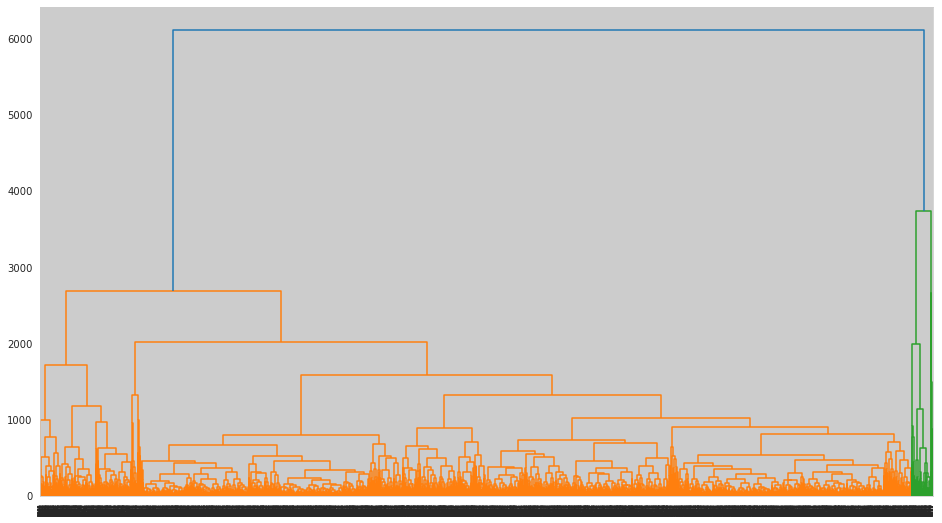

In [12]:
Z = hierarchy.linkage(distance_matrix_square_form, 'complete')
dendro = hierarchy.dendrogram(Z)